# OBJECTIVE : <br>

The objective of this business problem is to predict the taxi fare for a given taxi ride.  Since we have a target variable available which is a continuous numerical data, hence this problem falls into Supervised- Regression technique.

In [8]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.preprocessing import StandardScaler
#import datetime as date,time
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split,GridSearchCV,learning_curve
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression,Ridge
from sklearn.svm import SVR
from sklearn.metrics import accuracy_score,mean_absolute_error,mean_squared_error,r2_score
from sklearn.model_selection import KFold
from collections import defaultdict
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
#from xgboost import XGBRegressor
%matplotlib inline

# Read train and Test Data

In [9]:
train_data=pd.read_csv("train.csv")
test_data=pd.read_csv("test.csv")

# Explore Data

In [10]:
print(train_data.shape)
print(test_data.shape)


(87958, 18)
(9774, 17)


In [11]:
# Summary of all variable
train_data.describe(include="all")

,TID,vendor_id,new_user,tolls_amount,tip_amount,mta_tax,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,rate_code,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,surcharge,fare_amount
count,87958,87958,87957,87958.000000,79150.000000,87958.000000,87958,87958,87958.000000,85346.000000,86168.000000,87958.000000,46235,87679.000000,87544.000000,87958,82693.000000,87958.000000
unique,87958,4,2,NaN,NaN,NaN,84892,84872,NaN,NaN,NaN,NaN,2,NaN,NaN,5,NaN,NaN
top,AIX000465524,DST000532,NO,NaN,NaN,NaN,2015-01-01 01:16:00,2015-09-13 01:18:00,NaN,NaN,NaN,NaN,N,NaN,NaN,CRD,NaN,NaN
freq,1,41722,87951,NaN,NaN,NaN,4,5,NaN,NaN,NaN,NaN,45440,NaN,NaN,51914,NaN,NaN
mean,NaN,NaN,NaN,0.271402,1.532579,0.497948,NaN,NaN,1.734908,-72.588214,39.991795,1.035312,NaN,-72.599128,39.995261,NaN,0.318153,15.225970
std,NaN,NaN,NaN,1.276428,2.369551,0.032496,NaN,NaN,1.401843,10.033457,5.509783,0.279604,NaN,9.992113,5.498756,NaN,0.361798,12.803014
min,NaN,NaN,NaN,0.000000,0.000000,-0.500000,NaN,NaN,0.000000,-81.169787,0.000000,0.000000,NaN,-74.436935,0.000000,NaN,-0.500000,0.000000
25%,NaN,NaN,NaN,0.000000,0.000000,0.500000,NaN,NaN,1.000000,-73.991988,40.735111,1.000000,NaN,-73.991470,40.733639,NaN,0.000000,8.150000
50%,NaN,NaN,NaN,0.000000,1.000000,0.500000,NaN,NaN,1.000000,-73.981738,40.752667,1.000000,NaN,-73.980077,40.752892,NaN,0.000000,11.400000
75%,NaN,NaN,NaN,0.000000,2.100000,0.500000,NaN,NaN,2.000000,-73.967010,40.767118,1.000000,NaN,-73.962918,40.768220,NaN,0.500000,17.000000


<b> Finding: </b> <br>
a. Tip Amount is missing for more than 700 rides <br>
b. Not every trip has a pick up latitude and a pick up longitude as the count of pick up latitude and longitude is less than total count : 87958 <br>
c. Similarly not every trip has a drop latitude and drop longitude as there is a difference in count of rows vs count of drop longitude and latitude <br>
d. Toll Amount has a mean of 0.27 and std deviation of 1.27 when min value, 25 percentile, 50 percentile, 75 percentile are all =0 and there is just one max value, further analysis of this column to understand the data spread would help in bringing more
understanding around this column.

## Correlation Plot 

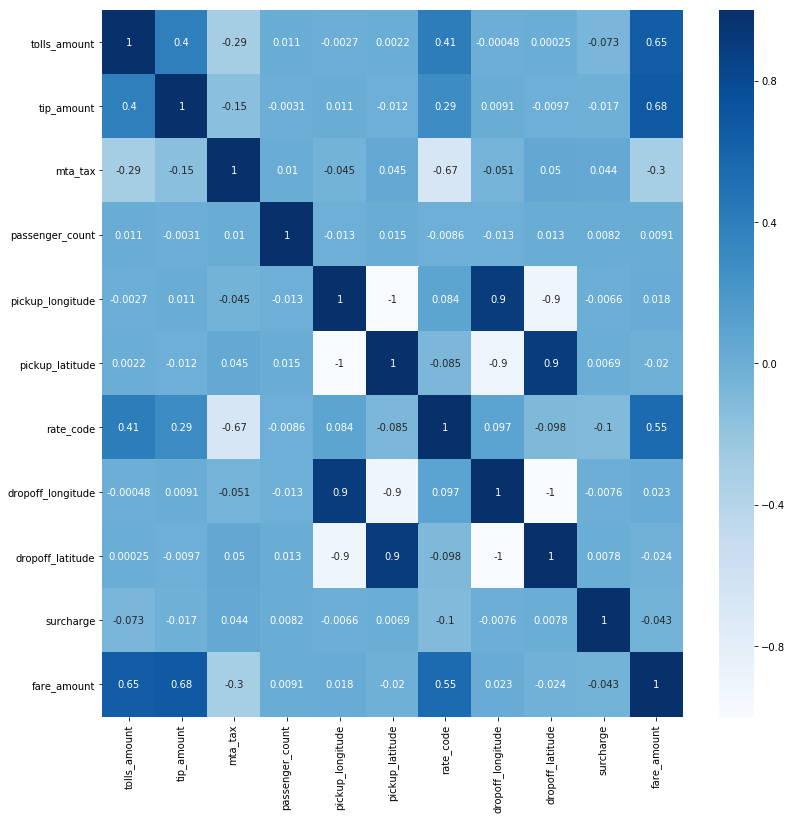

In [12]:
plt.figure(figsize=(13,13))
sns.heatmap(train_data.corr(),cmap='Blues',annot = True)
plt.show();

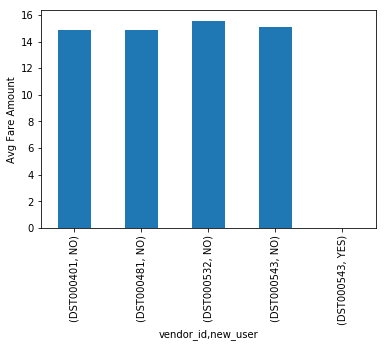

In [13]:
# plot Graph between Vendor Id ,New user and fare amount
train_data.groupby(["vendor_id","new_user"])['fare_amount'].mean().plot(kind="bar")
plt.ylabel("Avg Fare Amount")
# After Visualization, we can observe , fare amount is not charged to New user, also check the consistancy with test data , no new user-Yes in test, 
# we can say this is not useful feature
plt.show()

In [14]:
# Check NA value in train data
train_data.isna().sum()

TID                       0
vendor_id                 0
new_user                  1
tolls_amount              0
tip_amount             8808
mta_tax                   0
pickup_datetime           0
dropoff_datetime          0
passenger_count           0
pickup_longitude       2612
pickup_latitude        1790
rate_code                 0
store_and_fwd_flag    41723
dropoff_longitude       279
dropoff_latitude        414
payment_type              0
surcharge              5265
fare_amount               0
dtype: int64

In [15]:
# Replace all Blank with NA
train_data.replace(r'^\s*$', np.nan, regex=True,inplace=True)
test_data.replace(r'^\s*$', np.nan, regex=True,inplace=True)

In [16]:
# Check NA value in train dataset
train_data.isnull().sum()

TID                       0
vendor_id                 0
new_user                  1
tolls_amount              0
tip_amount             8808
mta_tax                   0
pickup_datetime           0
dropoff_datetime          0
passenger_count           0
pickup_longitude       2612
pickup_latitude        1790
rate_code                 0
store_and_fwd_flag    41723
dropoff_longitude       279
dropoff_latitude        414
payment_type              0
surcharge              5265
fare_amount               0
dtype: int64

In [17]:
# Check NA value in test dataset
test_data.isnull().sum()

TID                      0
vendor_id                0
new_user                 0
tolls_amount             0
tip_amount             942
mta_tax                  0
pickup_datetime          0
dropoff_datetime         0
passenger_count          0
pickup_longitude       296
pickup_latitude        199
rate_code                0
store_and_fwd_flag    4602
dropoff_longitude       28
dropoff_latitude        55
payment_type             0
surcharge              595
dtype: int64

## Imputation

In [18]:
# Remove NA value from both train and test data
train_data['store_and_fwd_flag'].fillna('N',inplace=True)
train_data['surcharge'].fillna(0.0,inplace=True)
train_data['tip_amount'].fillna(0.0,inplace=True)
train_data.dropna(subset=['pickup_datetime','dropoff_datetime','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude'],inplace=True)

test_data['store_and_fwd_flag'].fillna('N',inplace=True)
test_data['surcharge'].fillna(0.0,inplace=True)
test_data['tip_amount'].fillna(0.0,inplace=True)
#test_data.dropna(subset=['pickup_datetime','dropoff_datetime','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude'],inplace=True)

# Visualization

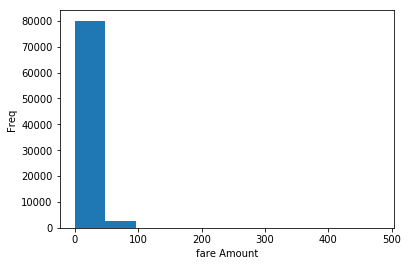

In [19]:
# Plot Target variable Hitogram graph
plt.hist(train_data.fare_amount)
plt.xlabel("fare Amount")
plt.ylabel("Freq")
# Many dataset has 0 fare amount which can be cancelled ride , need to remove from dataset
train_data=train_data[train_data.fare_amount > 0]

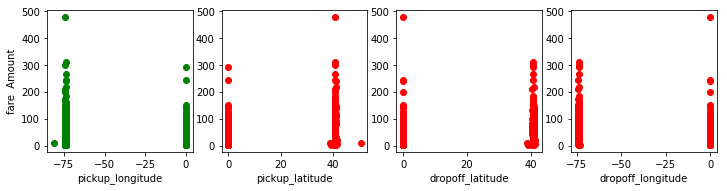

In [20]:
# Visualization of pickup and drop lat/lon feature
plt.figure(figsize=(12,12))
plt.subplot(4,4,1)
plt.scatter(train_data.pickup_longitude,train_data.fare_amount, c='green')
plt.xlabel("pickup_longitude")
plt.ylabel("fare  Amount")
plt.subplot(4,4,2)
plt.scatter(train_data.pickup_latitude,train_data.fare_amount, c='red')
plt.xlabel("pickup_latitude")
#plt.ylabel("fare  Amount")
#plt.show()
plt.subplot(4,4,3)
plt.scatter(train_data['dropoff_latitude'],train_data.fare_amount, c='red')
plt.xlabel("dropoff_latitude")
#plt.ylabel("fare  Amount")
#plt.show()
plt.subplot(4,4,4)
plt.scatter(train_data['dropoff_longitude'],train_data.fare_amount, c='red')
plt.xlabel("dropoff_longitude")
#plt.ylabel("fare  Amount")
plt.show()
# feature has 0 longitude and 0 longitude data (see graph) which needs to be remove
train_data=train_data[train_data.pickup_latitude !=0.0]
train_data=train_data[train_data.pickup_longitude!=0.0]
test_data=test_data[test_data.pickup_latitude !=0.0]
test_data=test_data[test_data.pickup_longitude!=0.0]

## Feature Engineering

In [21]:
# Define function for data conversion and add additional feature -(Travel time , month,year,hr,weekday and Distance)
def Add_new_feature(data=None ,drop_col=[]):
    if(len(data)>0):
        # convert Datatime column to dattime type
        data.pickup_datetime=pd.to_datetime(data.pickup_datetime,yearfirst=True)
        data.dropoff_datetime=pd.to_datetime(data.dropoff_datetime,yearfirst=True)
        # Add new feature total time duration
        data['Travel_time_sec']=data['dropoff_datetime']-data['pickup_datetime']
        # create time Dyration feature for each ride
        data['Travel_time_sec']=data['Travel_time_sec'].dt.total_seconds()
        data=data[data['Travel_time_sec']!=0]
        # Add travel Time 
        #data['Travel_time']=data['dropoff_datetime']-data['pickup_datetime']
        # Add Hour
        data['hr']=data.pickup_datetime.dt.hour
        data['month']=data.pickup_datetime.dt.month
        data['year']=data.pickup_datetime.dt.year
        data['weekday']=data.pickup_datetime.dt.weekday
        # Calculate Distance from given latitude and lonitude
        data['dlat']=data['dropoff_latitude']-data['pickup_latitude']
        data['dlat']=data['dlat'].apply(lambda x: math.radians(x))
        data['dlon']=data['dropoff_longitude']-data['pickup_longitude']
        data['dlon']=data['dlon'].apply(lambda x: math.radians(x))


        data['dlat']=data['dlat'].apply(lambda x : math.sin(x/2))
        data['dlon']=data['dlon'].apply(lambda x : math.sin(x/2))


        data['dlat']=data['dlat'].apply(lambda x : x*x)
        data['dlon']=data['dlon'].apply(lambda x : x*x)


        data['pickup_latitude']=data['pickup_latitude'].apply(lambda x: math.cos(math.radians(x)))
        data['dropoff_latitude']=data['dropoff_latitude'].apply(lambda x: math.cos(math.radians(x)))

        data['distance']=data['dlat']+(data['pickup_latitude']*data['dropoff_latitude']*data['dlon'])
        data['distance']=data['distance'].apply(lambda x: math.atan2(math.sqrt(x), math.sqrt(1-x)))
        data['distance']=data['distance'].apply(lambda x: 2*6371*x)
        data=data.drop(columns=drop_col,axis=1)
        return data

In [22]:
# Add new feature and delete feature which are not required
train_data=Add_new_feature(data=train_data,drop_col=['TID','dlat','dlon','pickup_latitude','pickup_longitude','dropoff_longitude','dropoff_latitude','pickup_datetime','dropoff_datetime','new_user','store_and_fwd_flag'])
test_data=Add_new_feature(data=test_data,drop_col=['TID','dlat','dlon','pickup_latitude','pickup_longitude','dropoff_longitude','dropoff_latitude','pickup_datetime','dropoff_datetime','new_user','store_and_fwd_flag'])

In [23]:
print(test_data.columns)

Index(['vendor_id', 'tolls_amount', 'tip_amount', 'mta_tax', 'passenger_count',
       'rate_code', 'payment_type', 'surcharge', 'Travel_time_sec', 'hr',
       'month', 'year', 'weekday', 'distance'],
      dtype='object')


Text(0, 0.5, 'Fare amount')

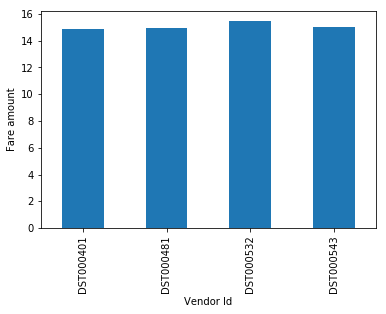

In [24]:
# Visualize Vendor Id features
train_data.groupby('vendor_id')['fare_amount'].mean().plot(kind='bar')
plt.xlabel("Vendor Id")
plt.ylabel("Fare amount")


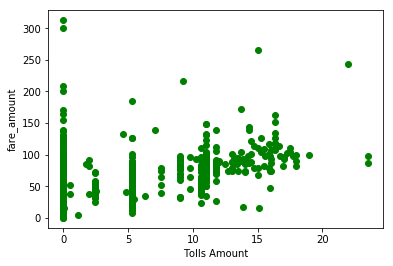

In [25]:
# Visualize Tolls amount with fareamount
plt.scatter(train_data.tolls_amount,train_data.fare_amount ,c='green')
plt.xlabel("Tolls Amount")
plt.ylabel("fare_amount")
plt.show()

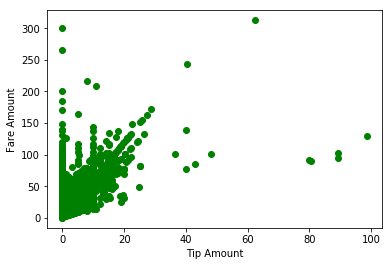

In [26]:
# Visualize Tip amount with fareamount
plt.scatter(train_data.tip_amount,train_data.fare_amount ,c='green')
plt.xlabel("Tip Amount")
plt.ylabel("Fare Amount")
plt.show()

Text(0, 0.5, 'Freq')

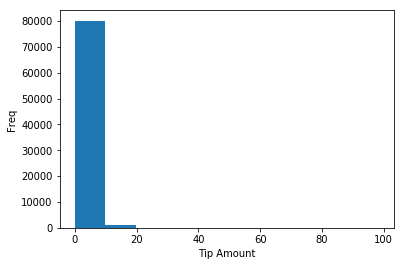

In [27]:
plt.hist(train_data.tip_amount)
plt.xlabel("Tip Amount")
plt.ylabel("Freq")

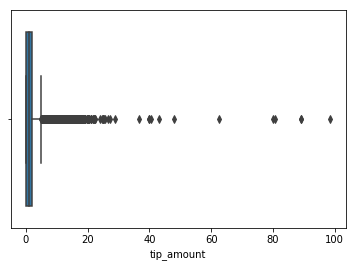

In [28]:
sns.boxplot(train_data.tip_amount)
plt.show()

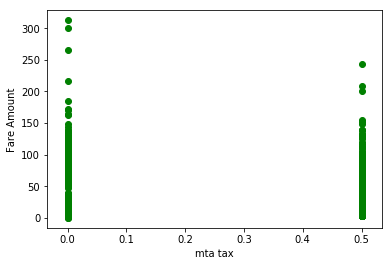

In [29]:
# Visualize mta tax with fareamount
plt.scatter(train_data.mta_tax,train_data.fare_amount ,c='green')
plt.xlabel("mta tax")
plt.ylabel("Fare Amount")
plt.show()

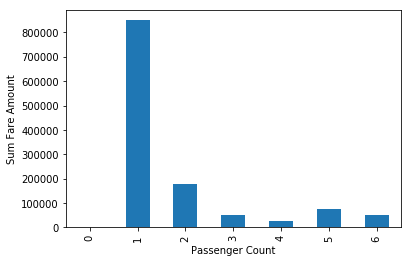

In [30]:
# Visualize Passenger count with fareamount
x=train_data.groupby(by="passenger_count")['fare_amount'].sum()
x.plot(kind='bar')
plt.xlabel("Passenger Count")
plt.ylabel("Sum Fare Amount")
plt.show()

# After visualizing we understand passenger prefer single ride 

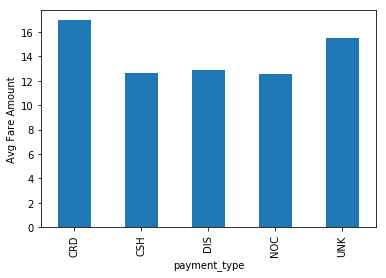

In [31]:
# Visualize payment_type with fareamount
x=train_data.groupby(by="payment_type")['fare_amount'].mean()
x.plot(kind='bar')
plt.xlabel("payment_type")
plt.ylabel("Avg Fare Amount")
plt.show()

# This is good feature to consider

Text(0.5, 0, 'Travel time in sec')

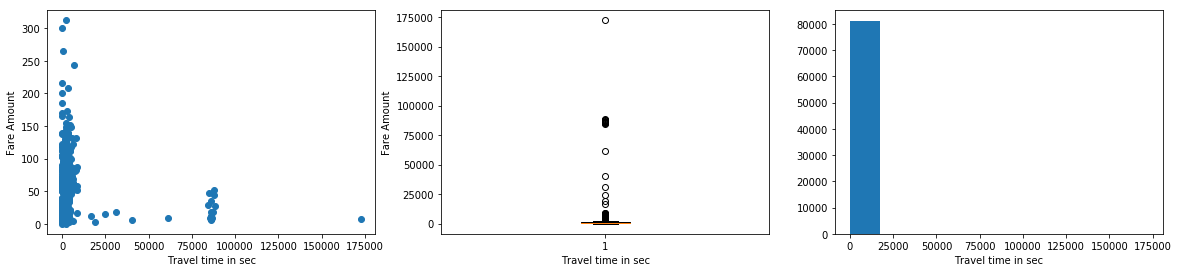

In [32]:
# Visualize feature Travel time
plt.figure(figsize=(20,14))
plt.subplot(3,3,1)
plt.scatter(train_data.Travel_time_sec,train_data.fare_amount)
plt.xlabel("Travel time in sec")
plt.ylabel("Fare Amount")
plt.subplot(3,3,2)
plt.boxplot(train_data.Travel_time_sec)
plt.xlabel("Travel time in sec")
plt.ylabel("Fare Amount")
plt.subplot(3,3,3)
plt.hist(x=train_data.Travel_time_sec,bins=10)
plt.xlabel("Travel time in sec")
# There are few outliers and few data points has zero time travel as well

In [33]:
#data=train_data
#data['travel_time_hr'] = data['Travel_time_sec']/3600
#sns.lineplot(x=data.travel_time_hr,y=data.fare_amount)

## Visualizations based on the the correlation 

# Correlation plot

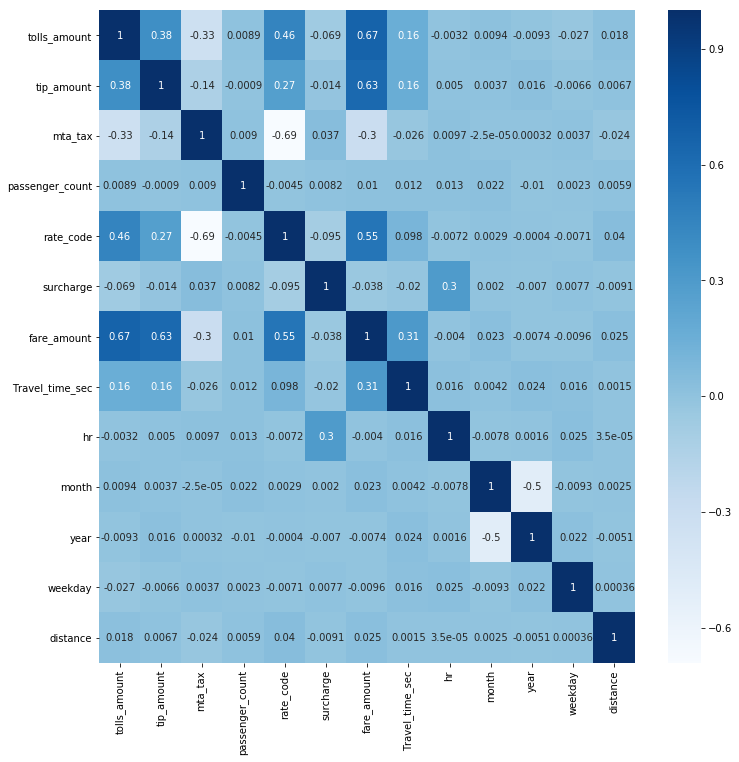

In [34]:
plt.figure(figsize=(12,12))
sns.heatmap(train_data.corr(),cmap='Blues',annot = True)
plt.show();

### Fare amount correlation  with Payment mode

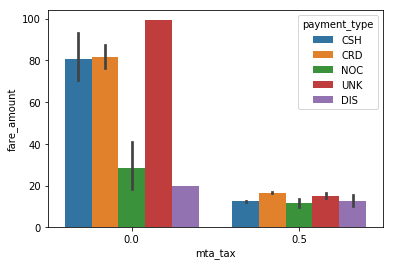

In [35]:
sns.barplot(train_data.mta_tax,train_data.fare_amount,train_data.payment_type)
plt.show()

### Tolls amount is maximun for the rate code 3  & lowest for 1

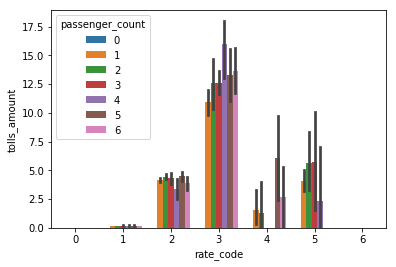

In [36]:
sns.barplot(x=train_data.rate_code, y=train_data.tolls_amount, hue=train_data.passenger_count)
plt.show()

### Passenger count relation with tolls_amount

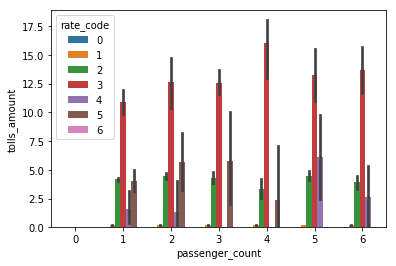

In [37]:
sns.barplot(x=train_data.passenger_count, y=train_data.tolls_amount, hue=train_data.rate_code)
plt.show()

### Tolls amount vs passenger count vs rate code

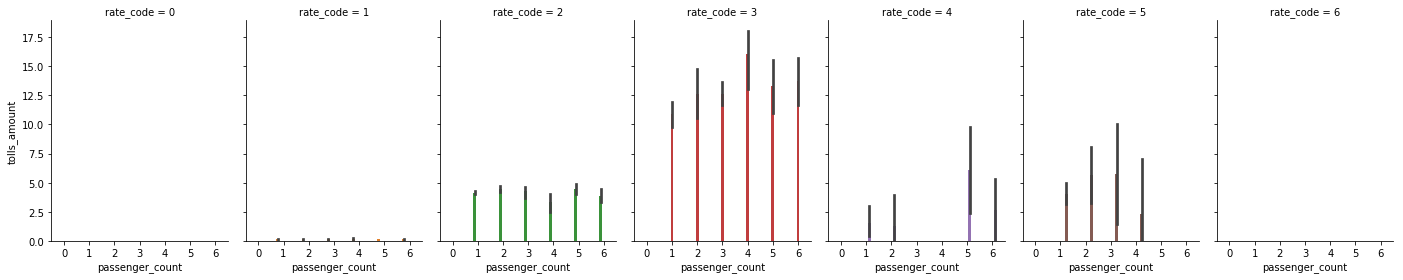

In [38]:
sns.catplot(x="passenger_count", y="tolls_amount",
...                 hue="rate_code", col="rate_code",
...                 data=train_data, kind="bar",
...                 height=4, aspect=.7);



### Hours count for various time period of day

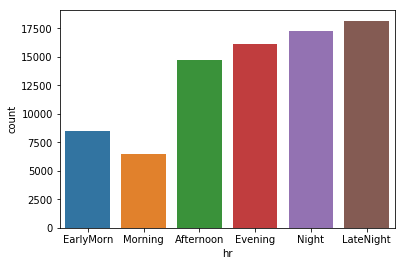

In [39]:
sns.countplot(x=pd.cut(train_data.hr, bins=6,labels=["EarlyMorn","Morning","Afternoon","Evening","Night","LateNight"]), data=train_data)

<b> Finding </b>: Surcharge is maximum for the 'Late Night' duration

In [40]:

#sns.catplot(x=pd.cut(train_data.hr, bins=6,labels=["EarlyMorn","Morning","Afternoon","Evening","Night","LateNight"]), y="surcharge", data=train_data)

### Fare Amount vs Distance

In [41]:
#sns.catplot(x="binned_hours", y="surcharge",kind="box", data=train_data);

In [42]:
#sns.catplot(x="binned_hours", y="surcharge",kind="bar", data=train_data);

In [43]:
# Remove outliers
train_data=train_data[train_data.Travel_time_sec < 25000]

In [44]:
# Drop row on which ride duration is less than 30 sec
train_data=train_data[train_data.Travel_time_sec > 30]

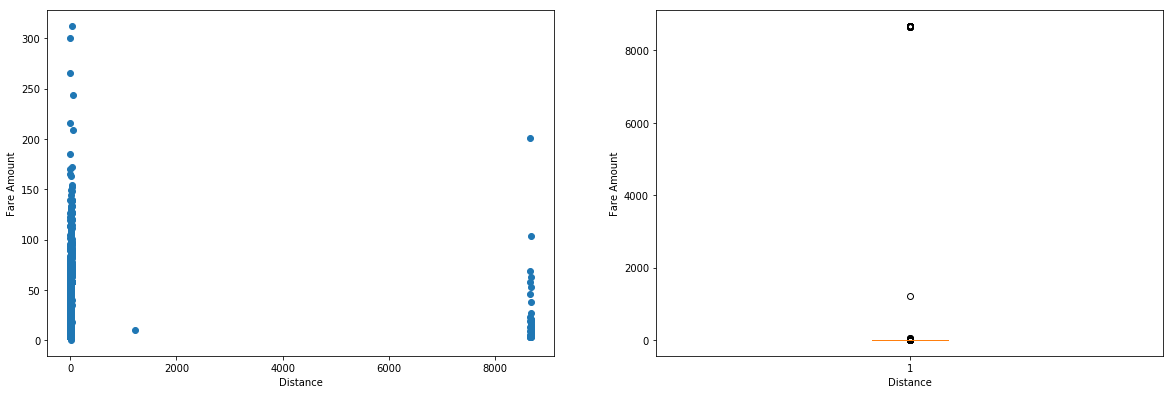

In [45]:
# Visualize feature Distance
plt.figure(figsize=(20,14))
plt.subplot(2,2,1)
plt.scatter(train_data.distance,train_data.fare_amount)
plt.xlabel("Distance")
plt.ylabel("Fare Amount")
plt.subplot(2,2,2)
plt.boxplot(train_data.distance)
plt.xlabel("Distance")
plt.ylabel("Fare Amount")
plt.show()

In [46]:
# Remove Outliers 
train_data=train_data[train_data.distance <1000]
print(train_data.shape)
train_data=train_data[train_data.distance >= 0 ]
print(train_data.shape)

(81019, 15)
(81019, 15)


In [47]:
test_data.columns

Index(['vendor_id', 'tolls_amount', 'tip_amount', 'mta_tax', 'passenger_count',
       'rate_code', 'payment_type', 'surcharge', 'Travel_time_sec', 'hr',
       'month', 'year', 'weekday', 'distance'],
      dtype='object')

In [48]:
# Segreegate num and cat col
num_col=['surcharge','tolls_amount','tip_amount','Travel_time_sec','distance','fare_amount','month','hr','year','weekday','rate_code']
cat_col=train_data.columns.difference(num_col)
cat_col_test=test_data.columns.difference(['surcharge','tolls_amount','tip_amount','Travel_time_sec','distance','month','hr','year','weekday','rate_code'])
print(cat_col)

Index(['mta_tax', 'passenger_count', 'payment_type', 'vendor_id'], dtype='object')


In [49]:
# Get Dummies for train ,validation and test data
#X_train=pd.get_dummies(data=X_train,columns=cat_col,drop_first=True)
train_data=pd.get_dummies(data=train_data,columns=cat_col,drop_first=True)
test_data=pd.get_dummies(data=test_data,columns=cat_col_test,drop_first=True)

In [50]:
print(test_data.columns.nunique())
print(train_data.columns.nunique())

24
25


In [51]:
train_data.columns.difference(test_data.columns)

Index(['fare_amount'], dtype='object')

In [52]:
# This function helps to standardize the numerical columns.
def scale_num_col(test=None,train=None,n_col=[],train_flag=True):
    std=StandardScaler()
    std.fit(train)
    if(train_flag==True):
        return pd.DataFrame(std.transform(train),columns=n_col)
    return pd.DataFrame(std.transform(test),columns=n_col)

In [53]:
# This function takes train, test or validation as an input and gives the regression matrix (mean absolute error 
# and root mean square error) For respective models like linear regression, decision tree etc.
def evaluation_matrix(X_train=None,X_validation=None,y_train=None,y_validation=None,test_data=None,model=""):
    # Linear Regression model
    if(model=="linear_reg"):
        lnr = LinearRegression()
        lnr.fit(X_train,y_train)
        pred_train = lnr.predict(X_train)
        pred_val = lnr.predict(X_validation)
        pred_test=lnr.predict(test_data)
        print(pred_test)
        #print(mean_absolute_error(y_train,pred_train))
        #print(mean_absolute_error(y_validation,pred_val))
        train_mae=mean_absolute_error(y_train,pred_train)
        val_mae=mean_absolute_error(y_validation,pred_val)
        RMSE=mean_squared_error(y_validation,pred_val)
        RMSE_train=mean_squared_error(y_train,pred_train)
        r_sq=r2_score(y_validation,pred_val)
        return {'Train_MAE' : train_mae  ,'val_MAE' :val_mae ,'r2_score':r_sq ,'Rmse' :RMSE,'Train_Rmse':RMSE_train}
    # Decision tree model
    if(model=="DT"):
        dtc = DecisionTreeRegressor()
        param_grid = {"max_depth" : [5,6,8,10,12,13,15,16],'max_features':['log2','sqrt']}

        dtc_cv_grid = GridSearchCV(estimator = dtc, param_grid = param_grid,
                                        scoring ="neg_mean_squared_error")
        dtc_cv_grid.fit(X_train, y_train)
        dtc_cv_grid.best_estimator_.fit(X_train, y_train)
        pred_train = dtc_cv_grid.best_estimator_.predict(X_train)
        pred_val = dtc_cv_grid.best_estimator_.predict(X_validation)
        print("Best Decision Tree Param : ",dtc_cv_grid.best_estimator_)
        #pred_test=dtc.predict(test_data)
        #print(mean_absolute_error(y_train,pred_train))
        #print(mean_absolute_error(y_validation,pred_val))        
        train_mae=mean_absolute_error(y_train,pred_train)
        val_mae=mean_absolute_error(y_validation,pred_val)
        RMSE=mean_squared_error(y_validation,pred_val)
        RMSE_train=mean_squared_error(y_train,pred_train)
        r_sq=r2_score(y_validation,pred_val)
        return {'Train_MAE' : train_mae  ,'val_MAE' :val_mae ,'r2_score':r_sq ,'Rmse' :RMSE,'Train_Rmse':RMSE_train} 
    # Ridge model
    if(model=="Ridge"):
        R=Ridge()
        parameter={'alpha':[1e-15,1e-10,1e-8,1e-2,1e-4,1e-3,1,5,10]}
        ridge_regressor=GridSearchCV(R,parameter,scoring="neg_mean_squared_error")
        ridge_regressor.fit(X_train,y_train)
        print("Best Estimator",ridge_regressor.best_estimator_)
        pred_train=pred_train=ridge_regressor.best_estimator_.predict(X_train)
        pred_val=ridge_regressor.best_estimator_.predict(X_validation)
        train_mae=mean_absolute_error(y_train,pred_train)
        val_mae=mean_absolute_error(y_validation,pred_val)
        RMSE=mean_squared_error(y_validation,pred_val)
        RMSE_train=mean_squared_error(y_train,pred_train)
        r_sq=r2_score(y_validation,pred_val)
        return {'Train_MAE' : train_mae  ,'val_MAE' :val_mae ,'r2_score':r_sq ,'Rmse' :RMSE,'Train_Rmse':RMSE_train}
    # Gboost model
    if(model=="GBoosting"):
        GBM_model = GradientBoostingRegressor(n_estimators=20,
                                       learning_rate=0.3,
                                       subsample=0.8)
        GBM_model.fit(X=X_train, y=y_train)
        pred_train = GBM_model.predict(X_train)
        pred_val = GBM_model.predict(X_validation)
        #pred_test=dtc.predict(test_data)
        #print(mean_absolute_error(y_train,pred_train))
        #print(mean_absolute_error(y_validation,pred_val))        
        train_mae=mean_absolute_error(y_train,pred_train)
        val_mae=mean_absolute_error(y_validation,pred_val)
        RMSE=mean_squared_error(y_validation,pred_val)
        RMSE_train=mean_squared_error(y_train,pred_train)
        r_sq=r2_score(y_validation,pred_val)
        return {'Train_MAE' : train_mae  ,'val_MAE' :val_mae ,'r2_score':r_sq ,'Rmse' :RMSE,'Train_Rmse':RMSE_train}
    # Random forest model
    if(model=="RF"):
        rfc_grid = RandomForestRegressor(n_jobs=-1, max_features='sqrt')
        param_grid = {"n_estimators" : [7],
                   "max_depth" : [6,8,10]}

        rfc_cv_grid = GridSearchCV(estimator = rfc_grid, param_grid = param_grid,
                                        scoring ="neg_mean_squared_error")
        rfc_cv_grid.fit(X_train, y_train)
        rfc_cv_grid.best_estimator_.fit(X_train, y_train)
        pred_train = rfc_cv_grid.best_estimator_.predict(X_train)
        pred_val = rfc_cv_grid.best_estimator_.predict(X_validation)
        train_mae=mean_absolute_error(y_train,pred_train)
        val_mae=mean_absolute_error(y_validation,pred_val)
        RMSE=mean_squared_error(y_validation,pred_val)
        RMSE_train=mean_squared_error(y_train,pred_train)
        r_sq=r2_score(y_validation,pred_val)
        return {'Train_MAE' : train_mae  ,'val_MAE' :val_mae ,'r2_score':r_sq ,'Rmse' :RMSE,'Train_Rmse':RMSE_train}
    if(model=="XGB"):
        xgb_model=XGBRegressor()
        xgb_model.fit(X_train,y_train)
        pred_train = xgb_model.predict(X_train)
        pred_val = xgb_model.predict(X_validation)
        #pred_test=lnr.predict(test_data)
        #print(mean_absolute_error(y_train,pred_train))
        #print(mean_absolute_error(y_validation,pred_val))
        train_mae=mean_absolute_error(y_train,pred_train)
        val_mae=mean_absolute_error(y_validation,pred_val)
        RMSE=mean_squared_error(y_validation,pred_val)
        RMSE_train=mean_squared_error(y_train,pred_train)
        r_sq=r2_score(y_validation,pred_val)
        return {'Train_MAE' : train_mae  ,'val_MAE' :val_mae ,'r2_score':r_sq ,'Val_Rmse' :RMSE,'Train_Rmse':RMSE_train}

In [54]:
# This function takes train data, test data, numerical column and model name which you want to choose and returns
# the respective model matrix (MAE, RMSE for train, validation and test)
def Model_Matrix (taxi_train=None,test_data=None,num_col=[],model=""):
    MAE_matrix=defaultdict(list)
    D=[]
    # Apply Standarization in Test Data
    # Segreegate num and cat col
    #num_col=['tolls_amount','tip_amount','Travel_time_sec','distance']
    cat_col=test_data.columns.difference(num_col)
    
    # Apply Kfold Split
    kf = KFold(n_splits=3,random_state=101)
    X=taxi_train.copy().drop(columns=['fare_amount'])
    Y=taxi_train['fare_amount']
    X.reset_index(drop=True)
    Y.reset_index(drop=True)
    apply_once=0
    # Divide in train test split
    for train_index, test_index in kf.split(X):
        #print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_validation = X.iloc[train_index], X.iloc[test_index]
        y_train, y_validation = Y.iloc[train_index], Y.iloc[test_index]
        
        # Apply data conversion for all categorical comumns
        #cat_col=X_train.columns.difference(num_col)
        #X_train[cat_col] = X_train[cat_col].apply(lambda x: x.astype('object'))
        #X_validation[cat_col] = X_validation[cat_col].apply(lambda x: x.astype('object'))
        
        # Resetting the index value for train and validation
        X_train=X_train.reset_index(drop=True)
        X_validation=X_validation.reset_index(drop=True)
        
        #Apply standardisation on train data
        num_data = X_train.loc[:,num_col]
        cat_data = X_train.loc[:,cat_col]
        num_data1=scale_num_col(train=num_data,n_col=num_col,train_flag=True)
        X_train=pd.concat([num_data1,cat_data],axis=1,ignore_index=False)

        # Apply standardisation on validation data
        num_data_val = X_validation.loc[:,num_col]
        cat_data_val = X_validation.loc[:,cat_col]
        num_data_val=scale_num_col(test=num_data_val,train=num_data,n_col=num_col,train_flag=False)
        X_validation = pd.concat([num_data_val,cat_data_val],axis=1,ignore_index=False)
        
        # Apply standardisation on test data
        if(apply_once==0) :
            test_data[cat_col] = test_data[cat_col].apply(lambda x: x.astype('object'))
            test_data=test_data.reset_index(drop=True)
            num_data_test = test_data.loc[:,num_col]
            cat_data_test = test_data.loc[:,cat_col]
            num_data_test=scale_num_col(test=num_data_test,train=num_data,n_col=num_col,train_flag=False)
            test_data = pd.concat([num_data_test,cat_data_test],axis=1,ignore_index=False)
            apply_once=1
        # Store all the matrix in list for every iteration        
        D.append(evaluation_matrix(X_train,X_validation,y_train,y_validation,test_data,model))
    
    print(D)
    MAE_matrix=({'Train MAE' :(D[0]['Train_MAE']+D[1]['Train_MAE']+D[2]['Train_MAE'])/3,
                'Val MAE' :(D[0]['val_MAE']+D[1]['val_MAE']+D[2]['val_MAE'])/3,
                'R_SQ' :(D[0]['r2_score']+D[1]['r2_score']+D[2]['r2_score'])/3,
                'Rmse' :np.sqrt((D[0]['Rmse']+D[1]['Rmse']+D[2]['Rmse'])/3),
                'Train_Rmse':np.sqrt((D[0]['Train_Rmse']+D[1]['Train_Rmse']+D[2]['Train_Rmse'])/3)})
    return MAE_matrix

In [55]:
train_data.dtypes

tolls_amount           float64
tip_amount             float64
rate_code                int64
surcharge              float64
fare_amount            float64
Travel_time_sec        float64
hr                       int64
month                    int64
year                     int64
weekday                  int64
distance               float64
mta_tax_0.5              uint8
passenger_count_1        uint8
passenger_count_2        uint8
passenger_count_3        uint8
passenger_count_4        uint8
passenger_count_5        uint8
passenger_count_6        uint8
payment_type_CSH         uint8
payment_type_DIS         uint8
payment_type_NOC         uint8
payment_type_UNK         uint8
vendor_id_DST000481      uint8
vendor_id_DST000532      uint8
vendor_id_DST000543      uint8
dtype: object

## Model Selection

### Linear Regression

In [58]:
# Use model matrix function to apply linear regression model. 
Model_Matrix (taxi_train=train_data,test_data=test_data,num_col=['tolls_amount','tip_amount','Travel_time_sec','distance','surcharge','month','hr','year','weekday','rate_code'],model="linear_reg")

[14.85250781 12.95205808  7.54615873 ... 11.52676606  8.65514451
 19.25100733]
[14.72164684 12.98385132  7.50912795 ... 11.52013157  8.7149327
 19.13391527]
[14.90399478 13.01374808  7.32328984 ... 11.65337607  8.67077086
 19.11351983]
[{'Train_MAE': 1.2756350135222594, 'val_MAE': 1.2187724886397457, 'r2_score': 0.9380993795431571, 'Rmse': 9.188746264800102, 'Train_Rmse': 11.474774234119288}, {'Train_MAE': 1.2318667150012745, 'val_MAE': 1.2337848729058165, 'r2_score': 0.9361760684045182, 'Rmse': 9.645774674971822, 'Train_Rmse': 11.228845917390702}, {'Train_MAE': 1.16722406376682, 'val_MAE': 1.2315939977878125, 'r2_score': 0.9139112851608119, 'Rmse': 13.764598766688115, 'Train_Rmse': 9.24986201906963}]


{'Train MAE': 1.224908597430118,
 'Val MAE': 1.228050453111125,
 'R_SQ': 0.9293955777028291,
 'Rmse': 3.296418243410062,
 'Train_Rmse': 3.263611607334203}

### Decision tree

In [ ]:
# Use model matrix function to apply Decision Tree model. 
Model_Matrix (taxi_train=train_data,test_data=test_data,num_col=['tolls_amount','tip_amount','Travel_time_sec','distance','surcharge','month','hr','year','weekday','rate_code'],model="DT")

### Ridge regression

In [ ]:
# Use model matrix function to apply ridge regression model. 
Model_Matrix (taxi_train=train_data,test_data=test_data,num_col=['tolls_amount','tip_amount','Travel_time_sec','distance','surcharge','month','hr','year','weekday','rate_code'],model="Ridge")

### Gboost Model

In [ ]:
# Use model matrix function to apply gboost model. 
Model_Matrix (taxi_train=train_data,test_data=test_data,num_col=['tolls_amount','tip_amount','Travel_time_sec','distance','surcharge','month','hr','year','weekday','rate_code'],model="GBoosting")

### Random Forest

In [ ]:
# Use model matrix function to apply random forest. 
Model_Matrix (taxi_train=train_data,test_data=test_data,num_col=['tolls_amount','tip_amount','Travel_time_sec','distance','surcharge','month','hr','year','weekday','rate_code'],model="RF")

## Learning Curve for Linear regression

In [ ]:
features=['tolls_amount','tip_amount','Travel_time_sec','distance','surcharge','month','hr','year','weekday','rate_code']
target=['fare_amount']
train_sizes = [1, 16203,32406, 48609, 64812]
train_sizes, train_scores, validation_scores = learning_curve(
estimator = LinearRegression(),
X = train_data[features],
y = train_data[target], train_sizes = train_sizes, cv = 5,
scoring = 'neg_mean_squared_error')
print('Training scores:\n\n', train_scores)
print('\n', '-' * 70) # separator to make the output easy to read
print('\nValidation scores:\n\n', validation_scores)
train_scores_mean = -train_scores.mean(axis = 1)
validation_scores_mean = -validation_scores.mean(axis = 1)
print('Mean training scores\n\n', pd.Series(train_scores_mean, index = train_sizes))
print('\n', '-' * 20) # separator
print('\nMean validation scores\n\n',pd.Series(validation_scores_mean, index = train_sizes))
plt.style.use('seaborn')
plt.plot(train_sizes, train_scores_mean, label = 'Training error')
plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')
plt.ylabel('MSE', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves for a linear regression model', fontsize = 18, y = 1.03)
plt.legend()
plt.ylim(0,40)

# Decision Tree learning Curve

In [ ]:
features=['tolls_amount','tip_amount','Travel_time_sec','distance','surcharge','month','hr','year','weekday','rate_code']
target=['fare_amount']
train_sizes = [1, 16203,32406, 48609, 64812]
train_sizes, train_scores, validation_scores = learning_curve(
estimator = DecisionTreeRegressor( max_depth=9),
X = train_data[features],
y = train_data[target], train_sizes = train_sizes, cv = 5,
scoring = 'neg_mean_squared_error')
print('Training scores:\n\n', train_scores)
print('\n', '-' * 70) # separator to make the output easy to read
print('\nValidation scores:\n\n', validation_scores)
train_scores_mean = -train_scores.mean(axis = 1)
validation_scores_mean = -validation_scores.mean(axis = 1)
print('Mean training scores\n\n', pd.Series(train_scores_mean, index = train_sizes))
print('\n', '-' * 20) # separator
print('\nMean validation scores\n\n',pd.Series(validation_scores_mean, index = train_sizes))
plt.style.use('seaborn')
plt.plot(train_sizes, train_scores_mean, label = 'Training error')
plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')
plt.ylabel('MSE', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves for a decision tree model', fontsize = 18, y = 1.03)
plt.legend()
plt.ylim(0,50)

## Ridge learning Curve

In [ ]:
features=['tolls_amount','tip_amount','Travel_time_sec','distance','surcharge','month','hr','year','weekday','rate_code']
target=['fare_amount']
train_sizes = [1, 16203,32406, 48609, 64812]
train_sizes, train_scores, validation_scores = learning_curve(
estimator = Ridge(alpha=5),
X = train_data[features],
y = train_data[target], train_sizes = train_sizes, cv = 5,
scoring = 'neg_mean_squared_error')
print('Training scores:\n\n', train_scores)
print('\n', '-' * 70) # separator to make the output easy to read
print('\nValidation scores:\n\n', validation_scores)
train_scores_mean = -train_scores.mean(axis = 1)
validation_scores_mean = -validation_scores.mean(axis = 1)
print('Mean training scores\n\n', pd.Series(train_scores_mean, index = train_sizes))
print('\n', '-' * 20) # separator
print('\nMean validation scores\n\n',pd.Series(validation_scores_mean, index = train_sizes))
plt.style.use('seaborn')
plt.plot(train_sizes, train_scores_mean, label = 'Training error')
plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')
plt.ylabel('MSE', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves for a Ridge model', fontsize = 18, y = 1.03)
plt.legend()
plt.ylim(0,50)

# Random forest learing curve

In [ ]:
features=['tolls_amount','tip_amount','Travel_time_sec','distance','surcharge','month','hr','year','weekday','rate_code']
target=['fare_amount']
train_sizes = [1, 16203,32406, 48609, 64812]
train_sizes, train_scores, validation_scores = learning_curve(
estimator = RandomForestRegressor(n_estimators=7,max_depth=8),
X = train_data[features],
y = train_data[target], train_sizes = train_sizes, cv = 5,
scoring = 'neg_mean_squared_error')
print('Training scores:\n\n', train_scores)
print('\n', '-' * 70) # separator to make the output easy to read
print('\nValidation scores:\n\n', validation_scores)
train_scores_mean = -train_scores.mean(axis = 1)
validation_scores_mean = -validation_scores.mean(axis = 1)
print('Mean training scores\n\n', pd.Series(train_scores_mean, index = train_sizes))
print('\n', '-' * 20) # separator
print('\nMean validation scores\n\n',pd.Series(validation_scores_mean, index = train_sizes))
plt.style.use('seaborn')
plt.plot(train_sizes, train_scores_mean, label = 'Training error')
plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')
plt.ylabel('MSE', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves for a Random Forest model', fontsize = 18, y = 1.03)
plt.legend()
plt.ylim(0,50)

In [ ]:
## Gboost learning cureve

In [ ]:
features=['tolls_amount','tip_amount','Travel_time_sec','distance','surcharge','month','hr','year','weekday','rate_code']
target=['fare_amount']
train_sizes = [1, 16203,32406, 48609, 64812]
train_sizes, train_scores, validation_scores = learning_curve(
estimator = GradientBoostingRegressor(n_estimators=20,learning_rate=0.3,subsample=0.8),
X = train_data[features],
y = train_data[target], train_sizes = train_sizes, cv = 5,
scoring = 'neg_mean_squared_error')
print('Training scores:\n\n', train_scores)
print('\n', '-' * 70) # separator to make the output easy to read
print('\nValidation scores:\n\n', validation_scores)
train_scores_mean = -train_scores.mean(axis = 1)
validation_scores_mean = -validation_scores.mean(axis = 1)
print('Mean training scores\n\n', pd.Series(train_scores_mean, index = train_sizes))
print('\n', '-' * 20) # separator
print('\nMean validation scores\n\n',pd.Series(validation_scores_mean, index = train_sizes))
plt.style.use('seaborn')
plt.plot(train_sizes, train_scores_mean, label = 'Training error')
plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')
plt.ylabel('MSE', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves for a GBoost model', fontsize = 18, y = 1.03)
plt.legend()
plt.ylim(0,50)

In [ ]:
test_data.isna().sum()

In [57]:
test_data['distance'].fillna(0.0,inplace=True)